<a href="https://colab.research.google.com/github/hydrationn/AI-based-Representation-and-Problem-Solving/blob/main/20230313_2%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5_2_fruit_image_embedding_and_visualization_higher_dim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Embedding

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose


# Fruit Embedding through Classification and 2D Visualization

This notebook illustrates the technique of converting fruit images into numerical representations by classifying them with a Convolutional Neural Network (CNN). Additionally, we will employ t-SNE to visualize these numerical embeddings in two dimensions. The aim is to grasp the basics of image embedding and the effectiveness of visualizing high-dimensional data in a reduced dimensional space.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [ ]:
def set_seed_everything(seed=42):
    # Fix the random number generator seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Use deterministic algorithms and disable benchmark mode
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
set_seed_everything(42)

## Data Preparation

Before training our model, we need to prepare our dataset. This involves loading the dataset, pre-processing the images, and splitting the data into training and testing sets.


In [ ]:
#!mkdir data
!rm data.zip
!rm -r data
!wget 'https://www.dropbox.com/scl/fi/mf806inzv0x6abbb2su0k/fruit-dataset.zip?rlkey=gk7s9d14m6k9o1ru4whrgtwke&dl=1' -O data.zip
!unzip data.zip -d data/

rm: cannot remove 'data.zip': No such file or directory
rm: cannot remove 'data': No such file or directory
--2024-03-19 17:56:34--  https://www.dropbox.com/scl/fi/mf806inzv0x6abbb2su0k/fruit-dataset.zip?rlkey=gk7s9d14m6k9o1ru4whrgtwke&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc59c1e8c30f4b086d1c85670a6e.dl.dropboxusercontent.com/cd/0/inline/CPYg8OdJdGfvwujyZdCa2xTFmtT3TjKZ0e-5NphZhg7MtQKm3_tWeq38YTLSbVhUxcqkF-hYajtat3i1zNMKsyGQmavhNDElV7TB8vfuPK4eQ6vK_SazGtSYUGpkfEbCS1g/file?dl=1# [following]
--2024-03-19 17:56:35--  https://uc59c1e8c30f4b086d1c85670a6e.dl.dropboxusercontent.com/cd/0/inline/CPYg8OdJdGfvwujyZdCa2xTFmtT3TjKZ0e-5NphZhg7MtQKm3_tWeq38YTLSbVhUxcqkF-hYajtat3i1zNMKsyGQmavhNDElV7TB8vfuPK4eQ6vK_SazGtSYUGpkfEbCS1g/file?dl=1
Resolving uc59c1e8c30f4b086d1c85670a6e.dl.dropboxuserconten

In [ ]:
# Define transformations for dataset loading
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the images to 64x64 pixels
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
])

In [ ]:
# Loading training and test datasets
data_folder = './data'
train_dataset = datasets.ImageFolder(root=os.path.join(data_folder, 'train'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_folder, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


## Model Architecture

Here, we define the architecture of our CNN. Each layer's purpose is detailed, providing insights into why they are essential for image classification tasks.


In [ ]:
# A simple CNN (Convolutional Neural Network) model definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 100)
        self.fc2 = nn.Linear(100, 4)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()


    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        h = self.tanh(self.fc1(x))
        x = self.fc2(h)
        return x, h

## Model Training

With our model defined, we'll now compile and train it on our dataset. This section will explain the training process, including forward pass, loss calculation, backpropagation, and optimization.

In [ ]:
# model, loss and optimizers
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# training loop
num_epochs = 50  # Adjust the number of epochs as needed.
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (data, target) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs, _ = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:    # Output every 10 batches.
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

Epoch 1, Batch 10, Loss: 1.3584
Epoch 2, Batch 10, Loss: 0.6941
Epoch 3, Batch 10, Loss: 0.3902
Epoch 4, Batch 10, Loss: 0.3098
Epoch 5, Batch 10, Loss: 0.2093
Epoch 6, Batch 10, Loss: 0.1895
Epoch 7, Batch 10, Loss: 0.1419
Epoch 8, Batch 10, Loss: 0.1293
Epoch 9, Batch 10, Loss: 0.1277
Epoch 10, Batch 10, Loss: 0.1030
Epoch 11, Batch 10, Loss: 0.1062
Epoch 12, Batch 10, Loss: 0.0909
Epoch 13, Batch 10, Loss: 0.0885
Epoch 14, Batch 10, Loss: 0.0821
Epoch 15, Batch 10, Loss: 0.0682
Epoch 16, Batch 10, Loss: 0.0597
Epoch 17, Batch 10, Loss: 0.0607
Epoch 18, Batch 10, Loss: 0.0866
Epoch 19, Batch 10, Loss: 0.0864
Epoch 20, Batch 10, Loss: 0.0573
Epoch 21, Batch 10, Loss: 0.0469
Epoch 22, Batch 10, Loss: 0.0333
Epoch 23, Batch 10, Loss: 0.0321
Epoch 24, Batch 10, Loss: 0.0298
Epoch 25, Batch 10, Loss: 0.0285
Epoch 26, Batch 10, Loss: 0.0288
Epoch 27, Batch 10, Loss: 0.0207
Epoch 28, Batch 10, Loss: 0.0172
Epoch 29, Batch 10, Loss: 0.0201
Epoch 30, Batch 10, Loss: 0.0172
Epoch 31, Batch 10,

## 2D Visualization with t-SNE

After training, we'll use t-SNE to reduce the dimensionality of our feature space and visualize it in 2D. This section explains t-SNE and shows how to plot the 2D visualization.


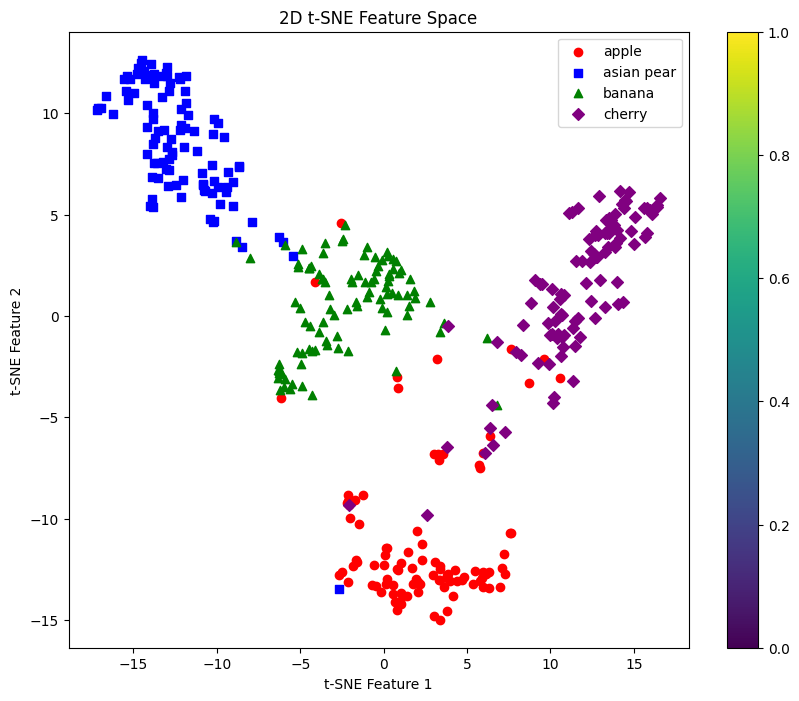

In [ ]:
# 2D visualization of test data using t-SNE.
model.eval()
h_list = []
labels_list = []

with torch.no_grad():
    for data, target in test_loader:
        _, h = model(data)
        h_list.append(h.cpu())
        labels_list.append(target.cpu())

h_list = torch.cat(h_list).numpy()
labels_list = torch.cat(labels_list).numpy()

# h_list normalization
h_list = (h_list - np.mean(h_list, axis=0)) / np.std(h_list, axis=0)

# t-SNE settings
tsne = TSNE(n_components=2, random_state=42, n_iter=300, learning_rate=200)
h_tsne = tsne.fit_transform(h_list)

class_names = train_dataset.classes

# markers and colors
markers = ['o', 's', '^', 'D']
colors = ['red', 'blue', 'green', 'purple']

# t-SNE visualization
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    idxs = labels_list == i
    plt.scatter(h_tsne[idxs, 0], h_tsne[idxs, 1], c=colors[i], label=class_name, marker=markers[i])

plt.colorbar()
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('2D t-SNE Feature Space')
plt.legend()
plt.show()


# Conclusion

This notebook provided a step-by-step guide to classifying fruits and visualizing them in 2D. Through this process, we learned about CNN architectures, data preparation, model training, and the usefulness of t-SNE for visualization.
